In [1]:
##For人工智慧用

In [2]:
import os
import requests
from bs4 import BeautifulSoup
dataurl = 'https://www.google.com/search?ei=BNaMXYDtB-u2mAX3pJm4Dg&yv=3&q={}&tbm=isch&vet=10ahUKEwiA_4Hl4-7kAhVrG6YKHXdSBucQuT0IZSgB.BNaMXYDtB-u2mAX3pJm4Dg.i&ved=0ahUKEwiA_4Hl4-7kAhVrG6YKHXdSBucQuT0IZSgB&ijn=2&start={}&asearch=ichunk&async=_id:rg_s,_pms:s,_jsfs:Ffpdje,_fmt:pc'

def getIdolImg(keyword, dstpath, num):
    for i in range(num):
        res = requests.get(dataurl.format(keyword, i * 100))
        soup = BeautifulSoup(res.text, 'lxml')
        for ele in soup.select('img'):
            imgurl = ele.get('src')
            if imgurl:
             fname = imgurl.split('tbn:')[1]
            else:
              imgurl = ele.get('data-src')
              fname = imgurl.split('tbn:')[1]
            with open(dstpath + fname + '.jpg', 'wb') as f:
                res2 = requests.get(imgurl)
                f.write(res2.content)   

In [3]:
inputname = input("圖搜名稱:")
inputnum = int(input("圖片數量(*100):"))
filename = inputname +'photos/'
filename

if not os.path.exists(filename):
    os.mkdir(filename)
getIdolImg(inputname, filename, inputnum)

圖搜名稱:長頸鹿
圖片數量(*100):1


In [4]:
from PIL import Image
def photoResize(srcpath, dstpath, size):
    if not os.path.exists(srcpath):
        os.mkdir(srcpath)
    if not os.path.exists(dstpath):
        os.mkdir(dstpath)
    for fname in os.listdir(srcpath):
        img = Image.open(srcpath + fname)
        (x, y) = img.size
        z = round(size*(y/x))
        #out = img.resize((size,z))
        out = img.resize((size,size))
        out.convert('RGB').save(dstpath + fname)
        
resizeornot = input("重新調整圖片大小?(y/n):")


if resizeornot.lower() == 'y':
    #size = int(input("輸入要調整之長度:"))
    size = int(input("輸入要調整之長度(N*N):"))
    resizefilename = 'Resize' + str(size) + filename    
    photoResize(filename, resizefilename, size)

    
else:
   print("bye!")
 

重新調整圖片大小?(y/n):y
輸入要調整之長度(N*N):100


In [40]:
import os
import numpy as np
from PIL import Image
import keras
def appendImgToList(foldername,imglist):
    if not os.path.exists(foldername):
        os.mkdir(foldername)
    for fname in os.listdir(foldername):
        img = Image.open(foldername + fname)
        imgarray = np.array(img)
        imgarray = (imgarray - np.min(imgarray))/(np.max(imgarray)-np.min(imgarray))
        imglist.append(imgarray)


In [41]:
penguin_img_list=[]
deer_img_list=[]
giraffe_img_list=[]

appendImgToList('企鵝訓練/',penguin_img_list)
appendImgToList('鹿訓練/',deer_img_list)
appendImgToList('長頸鹿訓練/',giraffe_img_list)
#把list整理成array
penguin_img_arr = np.asarray(penguin_img_list)
deer_img_arr = np.asarray(deer_img_list)
giraffe_img_arr = np.asarray(giraffe_img_list)
#用0、1來標示該圖片是企鵝或是鹿
penguin_img_label = np.ones(penguin_img_arr.shape[0])*0
deer_img_label = np.ones(deer_img_arr.shape[0])*1
giraffe_img_label = np.ones(giraffe_img_arr.shape[0])*2
#製作了一個把企鵝、鹿變數都合在一起的總變數，將Label進行one hot轉換，把0、1變成 [1,0]、[0,1]

img_arr   = np.concatenate((penguin_img_arr, deer_img_arr, giraffe_img_arr), axis = 0)
img_label = np.concatenate((penguin_img_label, deer_img_label, giraffe_img_label), axis = 0) 
img_label = keras.utils.to_categorical(img_label, num_classes = 3)




In [42]:
#打亂(跟Keras裡面的設計有關係)
import random
temp = list(zip(img_arr, img_label))
random.shuffle(temp)
img_arr, img_label = zip(*temp)
img_arr=np.asarray(img_arr)
img_label=np.asarray(img_label)

In [43]:
#基於Keras搭建一簡單的Sequential模型
from keras.models import Sequential
from keras.layers import Dense, SpatialDropout2D, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD,RMSprop
from keras.callbacks import EarlyStopping

model = Sequential()
#加入兩個Conv2D層，透過MaxPooling2D來進行取樣
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(100,100,3),padding='same',name='block1_conv2_1'))
model.add(Conv2D(64, (3, 3), activation='relu',padding='same',name='block1_conv2_2'))
model.add(MaxPooling2D(pool_size=(2, 2),name='block1_MaxPooling'))
#把一般常見的Dropout層替換成SpatialDropout2D，這樣的效果會比較好
model.add(SpatialDropout2D(0.25))

model.add(Conv2D(128, (3, 3), activation='relu',padding='same',name='block2_conv2_1'))
model.add(Conv2D(128, (3, 3), activation='relu',padding='same',name='block2_conv2_2'))
model.add(MaxPooling2D(pool_size=(2, 2),name='block2_MaxPooling'))
model.add(SpatialDropout2D(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu',name='final_output_1'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu',name='final_output_2'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='sigmoid',name='class_output'))
optimizer = RMSprop(lr=1e-4)
objective = 'binary_crossentropy'
model.compile(loss=objective, optimizer=optimizer, metrics=['accuracy'])
#加上EarlyStopping，自動地在模型不再進步時停下來，避免時間的浪費以及避免過擬合
EStop = EarlyStopping(monitor='val_acc', min_delta=0, 
                      patience=10, verbose=1, mode='auto')


In [44]:
#開始訓練
#給一個history變數位置，就可以把整個訓練的過程記錄下來
#引用time這個函式庫，並把當下時間給記錄下來，這樣在儲存Model時，就可以把時間給紀錄進去，避免覆蓋掉之前檔案的情況發生
#而timestr這個變數在之後儲存時也都會用到
#時間太長可先把epochs=100(accuracy約0.95)改epochs=30(accuracy約0.8)

history = model.fit(img_arr, img_label, batch_size=64, epochs=30,shuffle=True, validation_split=0.2,callbacks=[EStop])

import time
timestr = time.strftime("%Y%m%d_%H%M%S")
model.save('catdog_model_{}.h5'.format(timestr)) 

Train on 184 samples, validate on 46 samples
Epoch 1/30
184/184 [==============================] - 24s 133ms/step - loss: 0.6874 - accuracy: 0.5543 - val_loss: 0.6453 - val_accuracy: 0.6667
Epoch 2/30


//anaconda3/lib/python3.7/site-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


184/184 [==============================] - 18s 97ms/step - loss: 0.6681 - accuracy: 0.6341 - val_loss: 0.6496 - val_accuracy: 0.6667
Epoch 3/30
184/184 [==============================] - 18s 97ms/step - loss: 0.6555 - accuracy: 0.6141 - val_loss: 0.6480 - val_accuracy: 0.6667
Epoch 4/30
184/184 [==============================] - 18s 97ms/step - loss: 0.6533 - accuracy: 0.6286 - val_loss: 0.6368 - val_accuracy: 0.6667
Epoch 5/30
184/184 [==============================] - 20s 110ms/step - loss: 0.6399 - accuracy: 0.6449 - val_loss: 0.6311 - val_accuracy: 0.6667
Epoch 6/30
184/184 [==============================] - 18s 97ms/step - loss: 0.6449 - accuracy: 0.6413 - val_loss: 0.6282 - val_accuracy: 0.6667
Epoch 7/30
184/184 [==============================] - 18s 99ms/step - loss: 0.6440 - accuracy: 0.6341 - val_loss: 0.6230 - val_accuracy: 0.6667
Epoch 8/30
184/184 [==============================] - 18s 96ms/step - loss: 0.6326 - accuracy: 0.6141 - val_loss: 0.6116 - val_accuracy: 0.6667
Ep

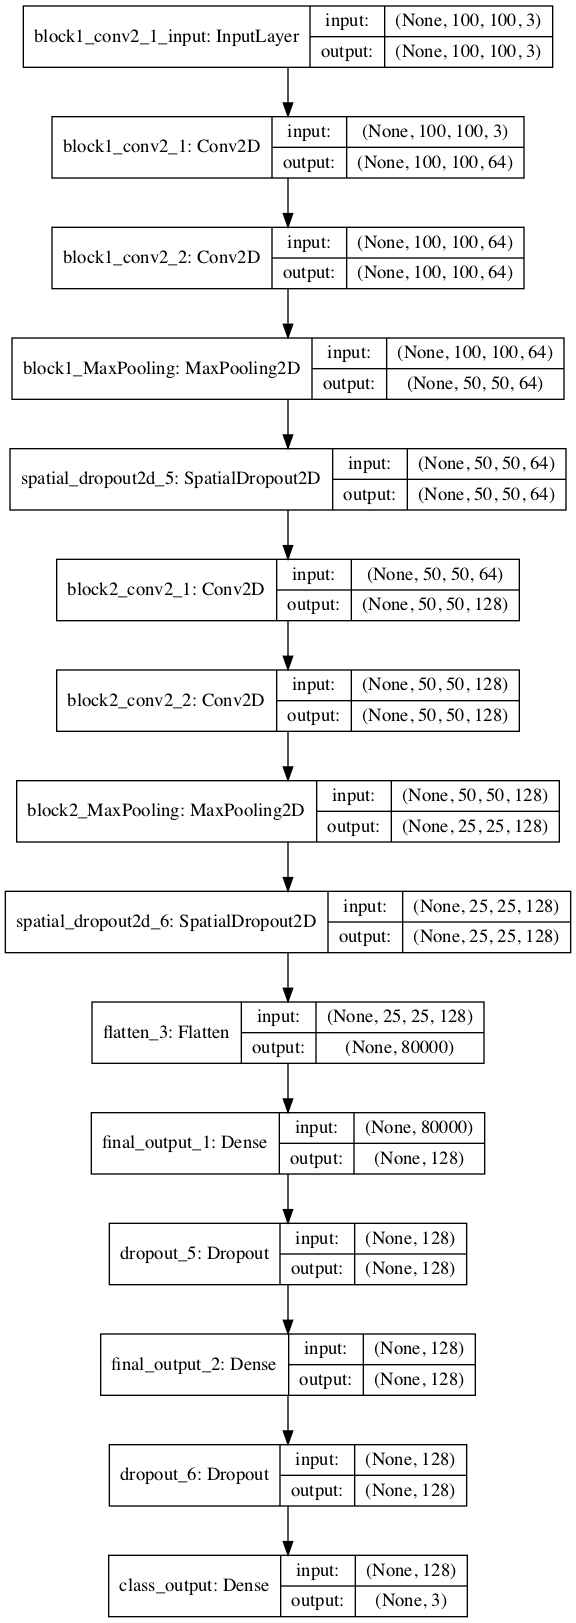

In [45]:
#透過Keras內建的畫圖功能畫出來

# Model Structure
from keras.utils import plot_model
plot_model(model, to_file='model_{}.png'.format(timestr),show_shapes=True, show_layer_names=True)


In [46]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv2_1 (Conv2D)      (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2_2 (Conv2D)      (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_MaxPooling (MaxPoolin (None, 50, 50, 64)        0         
_________________________________________________________________
spatial_dropout2d_5 (Spatial (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv2_1 (Conv2D)      (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2_2 (Conv2D)      (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_MaxPooling (MaxPoolin (None, 25, 25, 128)      

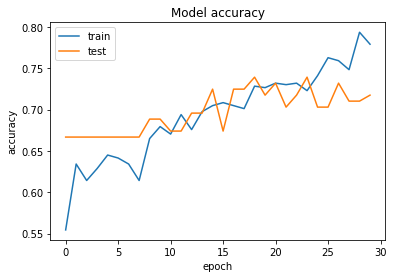

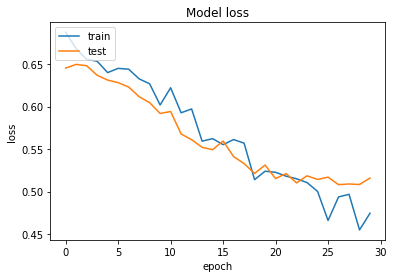

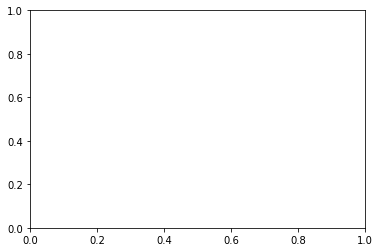

In [49]:
# Training History
import collections
import pandas as pd
hist = history.history

for key, val in hist.items(): # Count the number of epoch
    numepo = len(np.asarray(val))
    break
hist = collections.OrderedDict(hist)
pd.DataFrame(hist).to_excel('model_{}_history.xlsx'.format(timestr), index=True)

import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('Model accuracy_{}.png'.format(timestr))
plt.cla()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('Model loss_{}.png'.format(timestr))
plt.cla()